In [1]:
import segmentation_models_pytorch as smp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
import os

from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from scripts.config import Config
from scripts.utils import (CellDataset, 
                           im_convert, 
                           display_dataset,
                           get_img_paths,
                           make_model)

from scripts.train import train
# %matplotlib inline

config = Config()
sns.set() 

In [2]:
df_train = pd.read_csv(config.TRAIN_CSV)

In [3]:
df_train.head()

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73585 entries, 0 to 73584
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 73585 non-null  object
 1   annotation         73585 non-null  object
 2   width              73585 non-null  int64 
 3   height             73585 non-null  int64 
 4   cell_type          73585 non-null  object
 5   plate_time         73585 non-null  object
 6   sample_date        73585 non-null  object
 7   sample_id          73585 non-null  object
 8   elapsed_timedelta  73585 non-null  object
dtypes: int64(2), object(7)
memory usage: 5.1+ MB


In [5]:
train_images_path = get_img_paths(config.TRAIN_PATH)

100%|██████████| 606/606 [00:00<00:00, 201822.16it/s]


In [6]:
gb = df_train.groupby('id')
image_ids = list(df_train.id.unique())

image_id = image_ids[0]
df = gb.get_group(image_id)
image_id
# labels = df_train[df_train["id"] == image_id]["annotation"].tolist()

'0030fd0e6378'

In [7]:
vc = df_train["cell_type"].value_counts()

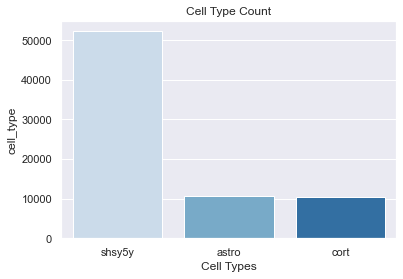

In [8]:
sns.barplot(x=df_train["cell_type"].unique(), y=vc, palette="Blues")
plt.title("Cell Type Count")
plt.xlabel("Cell Types")
plt.show()

In [9]:
ds_train = CellDataset(df_train)

X shape: (606,)
y shape: (606, 520, 704)


ValueError: Found array with dim 3. Estimator expected <= 2.

In [ ]:
dl_train = DataLoader(
    ds_train, 
    batch_size=config.BATCH_SIZE, 
    num_workers=4, 
    pin_memory=True, 
    shuffle=False
)

## Visualize Dataset

In [ ]:
display_dataset(train_images_path[100:150], cols=3, rows=3)

# Training

In [ ]:
model = smp.Unet("resnet34", encoder_weights="imagenet", activation=None)

In [ ]:
def dice_loss(input, target):
    input = torch.sigmoid(input)
    smooth = 1.0
    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    return ((2.0 * intersection + smooth) / (iflat.sum() + tflat.sum() + smooth))

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma):
        super().__init__()
        self.gamma = gamma

    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))
        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()
        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        return loss.mean()

In [ ]:
class MixedLoss(nn.Module):
    def __init__(self, alpha, gamma):
        super().__init__()
        self.alpha = alpha
        self.focal = FocalLoss(gamma)

    def forward(self, input, target):
        loss = self.alpha*self.focal(input, target) - torch.log(dice_loss(input, target))
        return loss.mean()

In [ ]:
criterion = MixedLoss(10.0, 2.0)
optimizer = optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
args = {"criterion": criterion,
        "optimizer": optimizer}

In [ ]:
# train(model, config, dl_train, True, args)